# Workshop 1 - Apply
    
In this notebook you will work on a homework assignment involving a Vierendeel frame.

Our matrix method implementation is now completely stored in a local package, consisting of three classes.

## Vierendeel frame

<center><figure>
  <IMG SRC="https://raw.githubusercontent.com/ibcmrocha/public/main/vierendeel.png" WIDTH=400 ALIGN="center">
      </figure></center>

With:

- $h = 1$
- $b = 1$
- $EI_r = 10000$
- $EI_k = 1000$
- $EA  = 1\cdot 10^{10}$
- $H = 100$


In the first half of this course last quarter, you have learned that the deformation of Vierendeel frames (an example of which is shown above) can be obtained in a simplified way by assuming the global deformation can be described by a shear beam with equivalent stiffness given by:

$$
k = \frac{24}{h\left(\displaystyle\frac{h}{EI_k}+\frac{b}{EI_r}\right)}
$$

Now that you have the tools to solve the original frame problem using the Matrix Method, your task in this assignment is to investigate the validity of this equivalent shear beam model.

Note that the checks only had a single element. For this model you need to obtain $\mathbf{K}$ and $\mathbf{f}$ of all elements and add them to the correct locations in the global stiffness matrix and force vector. To do that, make use of the `global_dofs` function of the Element class and the `np.ix_` Numpy utility function. (Tip: refer back to what you did in the `constrain` function).

Once you have a solution, use SymPy / Maple / pen and paper to solve a shear beam problem with the equivalent stiffness given above (It is very similar to the simple extension problem above) and compare the horizontal displacement at the point of application of $H$ for the two models.

Investigate how the two models compare for different values of $EA$, ranging from very small (*e.g.* $1\cdot 10^{-5}$) to very large (*e.g.* $1\cdot10^{10}$). What explains the behavior you observe?

In [86]:
import numpy as np
import matrixmethod as mm
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']

In [87]:
mm.Node.clear()
mm.Element.clear()

In [88]:
# Parameters
h = 1
b = 1
EIr = 10000
EIk = 1000
EA = 1e10
H = 100

In [89]:
# Nodes
nodes = []
nodes.append(mm.Node(0, 0))
nodes.append(mm.Node(b, 0))
nodes.append(mm.Node(0, -h))
nodes.append(mm.Node(b, -h))

# Elements
elems = []
elems.append(mm.Element(nodes[0], nodes[1]))
elems.append(mm.Element(nodes[2], nodes[3]))
elems.append(mm.Element(nodes[0], nodes[2]))
elems.append(mm.Element(nodes[1], nodes[3]))

# Sections
beam_section = {'EA': EA, 'EI': EIr}
column_section = {'EA': EA, 'EI': EIk}

elems[0].set_section(beam_section)
elems[1].set_section(beam_section)
elems[2].set_section(column_section)
elems[3].set_section(column_section)

# Constraints
con = mm.Constrainer()
con.fix_dof(nodes[0], 0)
con.fix_dof(nodes[0], 1)
con.fix_dof(nodes[1], 1)

# Loads
nodes[2].add_load([H, 0, 0])

# Check
for elem in elems:
    print(elem)

Element connecting:
node #1:
 This node has:
 - x coordinate=0,
 - z coordinate=0,
 - degrees of freedom=[0, 1, 2],
 - load vector=[0. 0. 0.]
with node #2:
 This node has:
 - x coordinate=1,
 - z coordinate=0,
 - degrees of freedom=[3, 4, 5],
 - load vector=[0. 0. 0.]
Element connecting:
node #1:
 This node has:
 - x coordinate=0,
 - z coordinate=-1,
 - degrees of freedom=[6, 7, 8],
 - load vector=[100.   0.   0.]
with node #2:
 This node has:
 - x coordinate=1,
 - z coordinate=-1,
 - degrees of freedom=[9, 10, 11],
 - load vector=[0. 0. 0.]
Element connecting:
node #1:
 This node has:
 - x coordinate=0,
 - z coordinate=0,
 - degrees of freedom=[0, 1, 2],
 - load vector=[0. 0. 0.]
with node #2:
 This node has:
 - x coordinate=0,
 - z coordinate=-1,
 - degrees of freedom=[6, 7, 8],
 - load vector=[100.   0.   0.]
Element connecting:
node #1:
 This node has:
 - x coordinate=1,
 - z coordinate=0,
 - degrees of freedom=[3, 4, 5],
 - load vector=[0. 0. 0.]
with node #2:
 This node has:
 - x

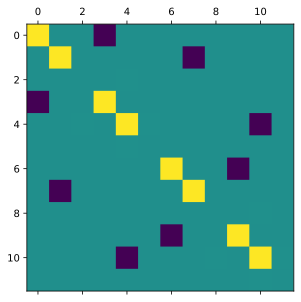

In [90]:
global_k = np.zeros((nodes[0].ndof, nodes[0].ndof))
global_f = np.zeros(nodes[0].ndof)

for elem in elems:
    elmat = elem.stiffness()
    idofs = elem.global_dofs()
    global_k[np.ix_(idofs, idofs)] += elmat
    
for node in nodes:
    global_f[node.dofs] += node.p

plt.matshow(global_k);

In [91]:
# Apply constraints
Kff, Ff = con.constrain(global_k, global_f)

u = np.matmul(np.linalg.inv(Kff), Ff)

print(u)
print(con.full_disp(u))

[-4.16667982e-04  4.99999538e-09 -4.16665674e-04  4.58334333e-03
 -4.99999806e-09 -4.16677659e-04  4.58333833e-03  4.99999806e-09
 -4.16675352e-04]
[ 0.00000000e+00  0.00000000e+00 -4.16667982e-04  4.99999538e-09
  0.00000000e+00 -4.16665674e-04  4.58334333e-03 -4.99999806e-09
 -4.16677659e-04  4.58333833e-03  4.99999806e-09 -4.16675352e-04]


In [92]:
#provided in case you want to solve the shear beam problem using SymPy
import sympy as sym
x, k, L, H = sym.symbols('x, k, L, H')
w = sym.Function('w')

ODE_shear = sym.Eq(w(x).diff(x, 2) * k, 0)
w = sym.dsolve(ODE_shear).rhs

# Relations
gamma = w.diff(x)
V = k * gamma

# Boundary conditions
eq1 = sym.Eq(w.subs(x, 0), 0)
eq2 = sym.Eq(V.subs(x, L), H)
C_sol = sym.solve([eq1, eq2], sym.symbols('C1 C2'))

w = w.subs(C_sol)
display(w)

H*x/k